# Estimating Equilibrium Climate Sensitivity (ECS) in CMIP6 models

*Definition:* Equilibrium Climate Sensitivity is defined as change in global-mean near-surface air temperature (GMST) change due to an instantaneous doubling of CO$_{2}$ concentrations and once the coupled ocean-atmosphere-sea ice system has acheived a statistical equilibrium (i.e. at the top-of-atmosphere, incoming solar shortwave radiation is balanced by reflected solar shortwave and outgoing thermal longwave radiation).

This notebook uses the ["Gregory method"](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2003GL018747) to approximate the ECS of CMIP6 models based on the first 150 years after an abrupt quadrupling of CO$_{2}$ concentrations. The "Gregory Method" extrapolates the quasi-linear relationship between GMST and radiative imbalance at the top-of-atmosphere to estimate how much warming would occur if the system were in radiative balance at the top-of-atmosphere, which is by definition the equilibrium response. In particular, we extrapolate the linear relationship that occurs between 100 and 150 years after the abrupt quadrupling. Since the radiative forcing due to CO$_{2}$ is a logarithmic function of the CO$_{2}$ concentration, the GMST change from a first doubling is roughly the same as for a second doubling (to first order, we can assume feedbacks as constant), which means that the GMST change due to a quadrupling of CO$_{2}$ is roughly $\Delta T_{4 \times \text{CO}_{2}} = 2 \times \text{ECS}$. See also [Mauritsen et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2018MS001400) for a detailed application of the Gregory Method (with modifications) for the case of one specific CMIP6 model, the MPI-M Earth System Model.

For another take on applying the Gregory method to estimate ECS, see [Angeline Pendergrass' code](https://github.com/apendergrass/cmip6-ecs).

In [1]:
# extrapolate linear relationship between GMST and radiative imbalance
# between gregory_limits[0] and gregory_limits[1]
gregory_limits = [0,150] 

### Python packages

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/cmip6-temperature-demo/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Data catalogs

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6). 

The file `https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv` in google cloud storage contains thousands of lines of metadata, each describing an individual climate model experiment's simulated data.

For example, the first line in the csv file contains the precipitation rate (`variable_id = 'pr'`), as a function of latitude, longitude, and time, in an individual climate model experiment with the BCC-ESM1 model (`source_id = 'BCC-ESM1'`) developed by the Beijing Climate Center (`institution_id = 'BCC'`). The model is *forced* by the forcing experiment SSP370 (`experiment_id = 'ssp370'`), which stands for the Shared Socio-Economic Pathway 3 that results in a change in radiative forcing of $\Delta F = 7.0$ W/m$^{2}$ from pre-industrial to 2100. This simulation was run as part of the `AerChemMIP` activity, which is a spin-off of the CMIP activity that focuses specifically on how aerosol chemistry affects climate.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,ch4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,clt,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
2,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,co2,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
3,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,evspsbl,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN
4,AerChemMIP,BCC,BCC-ESM1,piClim-CH4,r1i1p1f1,Amon,hfls,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/piClim-CH4/...,NaN


The file `pangeo-cmip6.json` describes the structure of the CMIP6 metadata and is formatted so as to be read in by the `intake.open_esm_datastore` method, which categorizes all of the data pointers into a tiered collection. For example, this collection contains the simulated data from 28691 individual experiments, representing 48 different models from 23 different scientific institutions. There are 190 different climate variables (e.g. sea surface temperature, sea ice concentration, atmospheric winds, dissolved organic carbon in the ocean, etc.) available for 29 different forcing experiments.

In [4]:
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 204562 entries:
	> 15 activity_id(s)

	> 26 institution_id(s)

	> 58 source_id(s)

	> 100 experiment_id(s)

	> 128 member_id(s)

	> 29 table_id(s)

	> 297 variable_id(s)

	> 9 grid_label(s)

	> 204562 zstore(s)

	> 60 dcpp_init_year(s)

Here, we show the various forcing experiments that climate modellers ran in these simulations. A few examples are:
 - `piControl` which fixes CO2 levels at pre-industrial concentrations of 300 ppm
 - `historical` which includes the historical evolution of greenhouse concentrations as well as historical volcanic eruptions, changes in solar luminosity, and changes in atmospheric aerosol concentrations (and some other, less impactful forcings).
 - `abrupt-4xCO2` in which the CO2 concentrations in an pre-industrial control simulation are abrupted quadrupled from 300 ppm to 1200 ppm.
 - `ssp585`, a `worst-case scenario` in which fossil-fueled development leads to a disastrous increase of $\Delta F = 8.5$ W/m$^{2}$ in radiative forcing.

In [5]:
df['experiment_id'].unique()

array(['piClim-CH4', 'piClim-NTCF', 'piClim-control', 'ssp370',
       'piClim-2xDMS', 'piClim-2xdust', 'piClim-2xfire', 'piClim-2xss',
       'piClim-BC', 'piClim-HC', 'piClim-N2O', 'piClim-OC', 'piClim-SO2',
       '1pctCO2-bgc', 'esm-ssp585', 'hist-bgc', 'amip-4xCO2',
       'amip-future4K', 'amip-m4K', 'amip-p4K', 'amip', 'abrupt-2xCO2',
       'abrupt-solp4p', 'abrupt-0p5xCO2', 'amip-lwoff', 'amip-p4K-lwoff',
       'abrupt-solm4p', 'aqua-4xCO2', 'aqua-control-lwoff',
       'aqua-control', 'aqua-p4K-lwoff', 'aqua-p4K', '1pctCO2',
       'abrupt-4xCO2', 'historical', 'piControl', 'esm-hist',
       'esm-piControl', 'ssp126', 'ssp245', 'ssp585',
       'esm-piControl-spinup', 'piControl-spinup', 'hist-GHG', 'hist-aer',
       'hist-nat', 'hist-CO2', 'hist-sol', 'hist-stratO3', 'hist-volc',
       'ssp245-GHG', 'ssp245-aer', 'ssp245-nat', 'ssp245-stratO3',
       'dcppA-assim', 'dcppA-hindcast', 'dcppC-hindcast-noAgung',
       'dcppC-hindcast-noElChichon', 'dcppC-hindcast-noPinatub

# Analysis of Climate Model Output Data

### Loading data

`intake-esm` enables loading data directly into an [xarray.DataArray](http://xarray.pydata.org/en/stable/api.html#dataset), a metadata-aware extension of numpy arrays. `xarray` objects leverage [dask](https://dask.org/) to only read data into memory as needed for any specific operation (i.e. lazy evaluation). Think of `xarray` Datasets as ways of conveniently organizing large arrays of floating point numbers (e.g. climate model data) on an n-dimensional discrete grid, with important metadata such as units, variable, names, etc.

Note that data on the cloud are in [zarr](https://zarr.readthedocs.io/en/stable/) format, an extension of the metadata-aware format [netcdf](https://www.unidata.ucar.edu/software/netcdf/) commonly used in geosciences.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

#### Choice of simulated forcing experiments

Here, we choose the `piControl` experiment (in which CO2 concentrations are held fixed at a pre-industrial level of ~300 ppm) and `abrupt-4xCO2` experiment (in which CO2 concentrations are instantaneously quadrupled - or doubled twice - from a pre-industrial controrl state). Since the radiative forcing of CO2 is roughly a logarithmic function of CO2 concentrations, the ECS is roughly independent of the initial CO2 concentration. Thus, if one doubling of CO2 results in $ECS$ of warming, then two doublings (or, a quadrupling) results in $2 \times ECS$ of warming.

Ideally, we would choose the `abrupt-2xCO2` forcing experiment, but this seems to be currently unavaiable in Google Cloud Storage.

In [6]:
cat_tas = col.search(experiment_id=['abrupt-4xCO2','piControl'],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
                 table_id='Amon',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id='tas',           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

cat_rad = col.search(experiment_id=['abrupt-4xCO2','piControl'],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
                 table_id='Amon',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id=['rsut','rsdt','rlut'],           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

In [25]:
# convert data catalog into a dictionary of xarray datasets
def drop_time_bounds(ds):
    if 'time_bounds' in ds.coords:
        ds = ds.drop('time_bounds')
    elif 'time_bnds' in ds.coords:
        ds = ds.drop('time_bnds')
    return ds

dset_dict_tas = cat_tas.to_dataset_dict(preprocess = drop_time_bounds, zarr_kwargs={'consolidated': True, 'decode_times': False})
dset_dict_rad = cat_rad.to_dataset_dict(preprocess = drop_time_bounds, zarr_kwargs={'consolidated': True, 'decode_times': False})

Progress: |█████████████████████████------------------------------------------------------| 31.2% Dropped
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 48 group(s)
Dropped
Progress: |-------------------------------------------------------------------------------| 0.0% Dropped
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 45 group(s)


In [26]:
ds_dict = {}
gmst_dict = {}
imbalance_dict = {}
for name, ds_rad in tqdm(dset_dict_rad.items()):
    model_name = name.split(".")[2]
    
    if not (('rsdt' in dset_dict_rad[name].keys()) & ('rsut' in dset_dict_rad[name].keys()) & ('rlut' in dset_dict_rad[name].keys())):
        continue
        
    ds_tas = dset_dict_tas[name]
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds_rad.dims) and ('latitude' in ds_rad.dims):
        ds_rad = ds_rad.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        ds_tas = ds_tas.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        
    ds_rad = xr.decode_cf(ds_rad) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    ds_tas = xr.decode_cf(ds_tas)
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_tas.coords:
        if coord not in ['lat','lon','time']:
            ds_tas = ds_tas.drop(coord)
            
    # drop redundant variables (like "height: 2m")
    for coord in ds_rad.coords:
        if coord not in ['lat','lon','time']:
            ds_rad = ds_rad.drop(coord)

    ## Calculate global-mean surface temperature (GMST)
    cos_lat_2d = np.cos(np.deg2rad(ds_tas['lat'])) * xr.ones_like(ds_tas['lon']) # effective area weights
    gmst = (
        (ds_tas['tas'] * cos_lat_2d).sum(dim=['lat','lon']) /
        cos_lat_2d.sum(dim=['lat','lon'])
    )
    
    ## Calculate global-mean top of atmosphere radiative imbalance (GMST)
    net_toa = ds_rad['rsdt'] - ds_rad['rsut'] - ds_rad['rlut']
    
    cos_lat_2d = np.cos(np.deg2rad(ds_rad['lat'])) * xr.ones_like(ds_rad['lon']) # effective area weights
    imbalance = (
        (net_toa * cos_lat_2d).sum(dim=['lat','lon']) /
        cos_lat_2d.sum(dim=['lat','lon'])
    )
    
    imbalance_dict[name] = imbalance.squeeze()

    # Add GMST to dictionary
    gmst_dict[name] = gmst.squeeze()
    
    # Add near-surface air temperature to dictionary
    ds_dict[name] = ds_tas

/srv/conda/envs/cmip6-temperature-demo/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/cmip6-temperature-demo/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/cmip6-temperature-demo/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/cmip6-temper

#### Split dictionary of all simulations into `piControl` and `abrupt-4xCO2` dictionaries

And get rid of any models that don't have both experiments available.

In [27]:
ctrl_dict = {} # dictionary that will hold spliced DataArrays
for name, ds in ds_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if 'piControl' not in name: continue
    ctrl_dict[model_name] = ds
    
abrupt_dict = {} # dictionary that will hold spliced DataArrays
for name, ds in ds_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('abrupt-4xCO2' not in name) or (model_name not in ctrl_dict.keys()): continue
    abrupt_dict[model_name] = ds

In [28]:
ctrl_gmst_dict = {} # dictionary that will hold spliced DataArrays
ctrl_imbalance_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if 'piControl' not in name: continue # keep only SSP simulations
    ctrl_gmst_dict[model_name] = gmst
    ctrl_imbalance_dict[model_name] = imbalance_dict[name]
    
abrupt_gmst_dict = {} # dictionary that will hold spliced DataArrays
abrupt_imbalance_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('abrupt-4xCO2' not in name) or (model_name not in ctrl_gmst_dict.keys()): continue # keep only SSP simulations
    abrupt_gmst_dict[model_name] = gmst
    abrupt_imbalance_dict[model_name] = imbalance_dict[name]
    
ctrl_gmst_dict = {} # dictionary that will hold spliced DataArrays
ctrl_imbalance_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    model_name = name.split(".")[2]
    if ('piControl' not in name) or (model_name not in abrupt_gmst_dict.keys()): continue # keep only SSP simulations
    ctrl_gmst_dict[model_name] = gmst
    ctrl_imbalance_dict[model_name] = imbalance_dict[name]

#### Pick first model arbitrarily for example application of Gregory method

In [29]:
model = 'CESM2'
for name in ctrl_gmst_dict.keys():
    if model == name:
        ctrl_gmst = ctrl_gmst_dict[name].groupby('time.year').mean('time').compute()
        ctrl_imbalance = ctrl_imbalance_dict[name].groupby('time.year').mean('time').compute()
        abrupt_gmst = abrupt_gmst_dict[name].groupby('time.year').mean('time').compute() - ctrl_gmst.mean(dim='year')
        abrupt_imbalance = abrupt_imbalance_dict[name].groupby('time.year').mean('time').compute() - ctrl_imbalance.mean(dim='year')

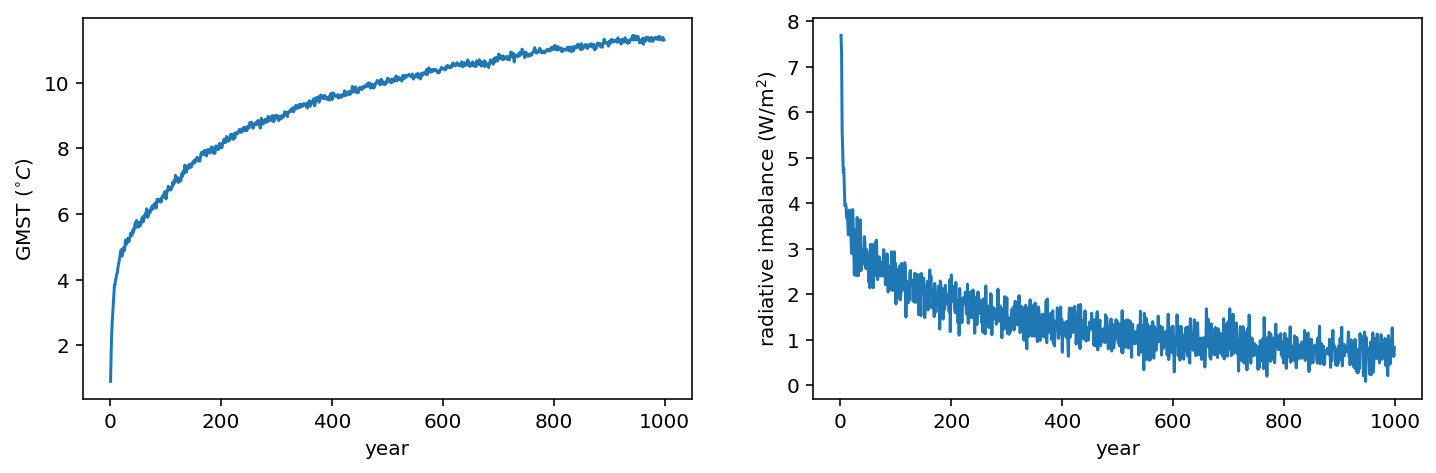

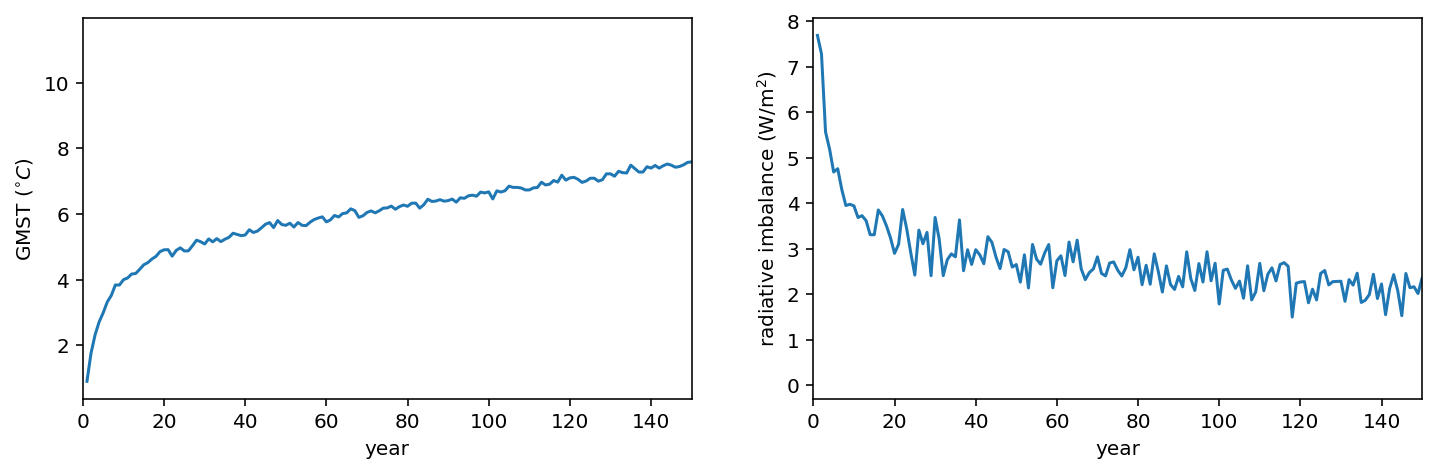

In [30]:
plt.figure(figsize=(12,3.5))
plt.subplot(1,2,1)
abrupt_gmst.plot()
plt.ylabel('GMST ($^{\circ}C$)')

plt.subplot(1,2,2)
abrupt_imbalance.plot()
plt.ylabel('radiative imbalance (W/m$^{2}$)');
plt.savefig('../figures/4xCO2_temperature_evolution.png', dpi=100, bbox_inches='tight')

plt.figure(figsize=(12,3.5))
plt.subplot(1,2,1)
abrupt_gmst.plot()
plt.xlim(gregory_limits)
plt.ylabel('GMST ($^{\circ}C$)')

plt.subplot(1,2,2)
abrupt_imbalance.plot()
plt.xlim(gregory_limits)
plt.ylabel('radiative imbalance (W/m$^{2}$)');

In [31]:
y_data = abrupt_imbalance.isel(year=slice(gregory_limits[0],gregory_limits[1]))
x_data = abrupt_gmst.isel(year=slice(gregory_limits[0],gregory_limits[1]))
a, b = np.polyfit(x_data,y_data,1)

ECS =  5.161240071872432


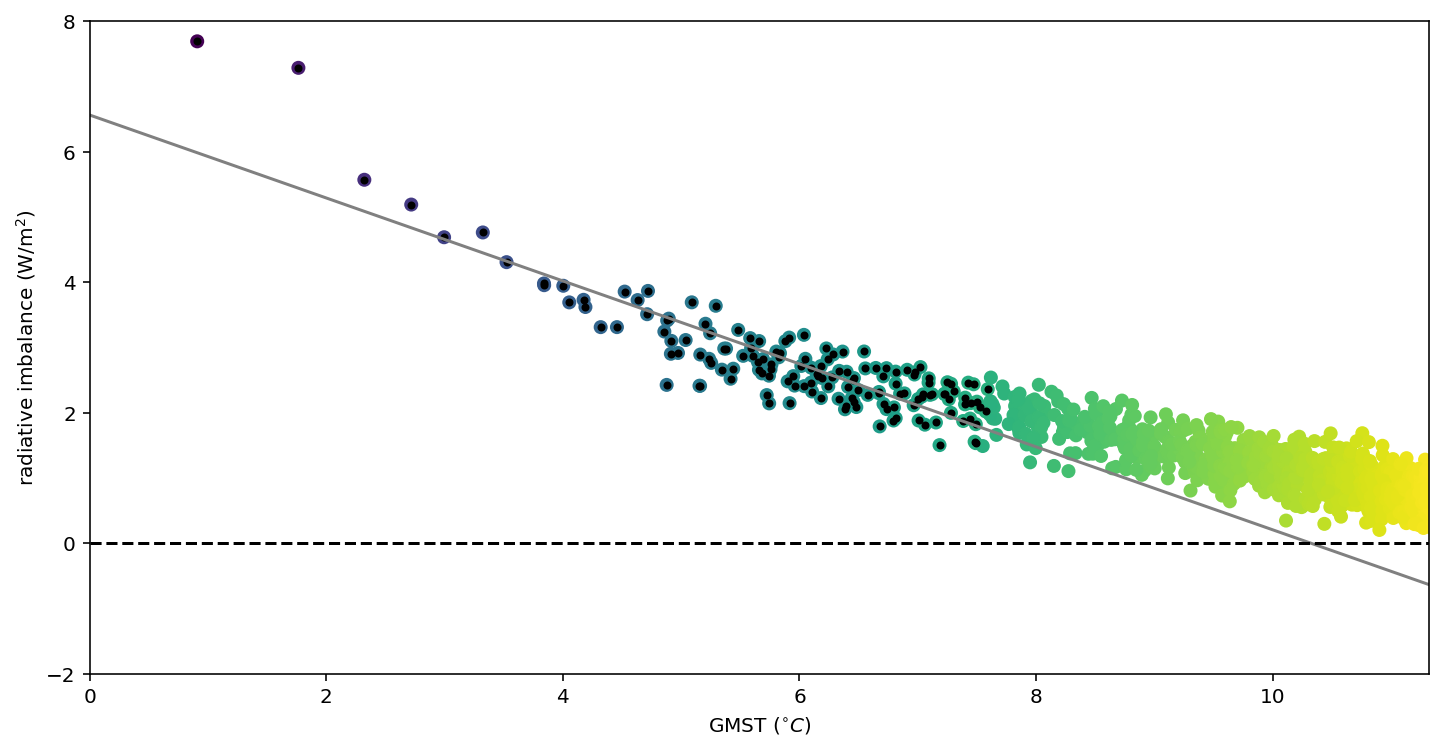

In [32]:
plt.scatter(abrupt_gmst, abrupt_imbalance, c = abrupt_gmst.values, cmap='viridis')
plt.scatter(x_data, y_data, marker='.', c = 'k', cmap='viridis')
x_extrapolate = np.arange(abrupt_gmst.min()-20,abrupt_gmst.min()+20., 0.1)
plt.plot(x_extrapolate, a*x_extrapolate + b, color='grey')

twoECS = b/(-a)
print("ECS = ", twoECS/2.)

plt.plot([0,twoECS + 1.], [0,0], "k--")
plt.xlim([0,twoECS + 1.])
plt.ylim([-2,8])
plt.xlabel('GMST ($^{\circ}C$)')
plt.ylabel('radiative imbalance (W/m$^{2}$)');
plt.savefig('../figures/Gregory_method_CESM2_example.png', dpi=100, bbox_inches='tight')

#### Eagerly compute ECS for each model, in preparation for plotting

The operations we have done up to this point to calculate the global-mean surface temperature were evaluated lazily. In other worse, we have created a blueprint for how we want to evaluate the calculations, but have not yet computing them. This lets us do things like multiply two 1 Tb arrays together even though they are each individually larger-than-memory.

Now we call xarray's `compute()` method to carry out the computations we defined in the for loop above for calculation the global-mean surface temperature anomaly roughly 100-150 years (1200-1800 months) after instantaneous quadrupling of CO2 relative to the last 50 years (600 months) of the control simulation.

In [33]:
ECS_dict = {}
results = {'ECS': {}, 'ctrl_gmst': {}, 'ctrl_imbalance': {}, 'abrupt_gmst': {}, 'abrupt_imbalance': {}}

for name in tqdm(ctrl_gmst_dict.keys()):
    results['ctrl_gmst'][name] = ctrl_gmst_dict[name].groupby('time.year').mean(dim='time').compute()
    results['ctrl_imbalance'][name] = ctrl_imbalance_dict[name].groupby('time.year').mean(dim='time').compute()
    
    results['abrupt_gmst'][name] = (
        abrupt_gmst_dict[name].groupby('time.year').mean(dim='time') -
        results['ctrl_gmst'][name].isel(year=slice(gregory_limits[0],gregory_limits[1])).mean(dim='year')
    ).compute()
    results['abrupt_imbalance'][name] = (
        abrupt_imbalance_dict[name].groupby('time.year').mean(dim='time') -
        results['ctrl_imbalance'][name].isel(year=slice(gregory_limits[0],gregory_limits[1])).mean(dim='year')
    ).compute()
    
    # Apply Gregory method to estimate ECS
    if results['abrupt_imbalance'][name].size >= gregory_limits[1]:
        y_data = results['abrupt_imbalance'][name].isel(year=slice(gregory_limits[0],gregory_limits[1])).compute()
        x_data = results['abrupt_gmst'][name].isel(year=slice(gregory_limits[0],gregory_limits[1])).compute()
        a, b = np.polyfit(x_data,y_data,1)

        results['ECS'][name] = b/(-a) / 2.0

In [34]:
results['ECS']

{'MIROC6': 2.571679992793863,
 'E3SM-1-0': 5.327854275356072,
 'CanESM5': 5.614675078786822,
 'BCC-CSM2-MR': 3.0219041781154377,
 'GFDL-ESM4': 2.679879548908625,
 'CESM2-WACCM': 4.746858814991468,
 'BCC-ESM1': 3.243438196242251,
 'GFDL-CM4': 3.934080254287022,
 'CESM2': 5.225059336140391,
 'GISS-E2-1-H': 3.0841129356317167,
 'CAMS-CSM1-0': 2.288186201608668,
 'GISS-E2-1-G': 2.7174072964820772,
 'NESM3': 4.612541962433655,
 'MRI-ESM2-0': 3.1627661850484663,
 'EC-Earth3-Veg': 4.300457395775987,
 'SAM0-UNICON': 3.6779398988613416}

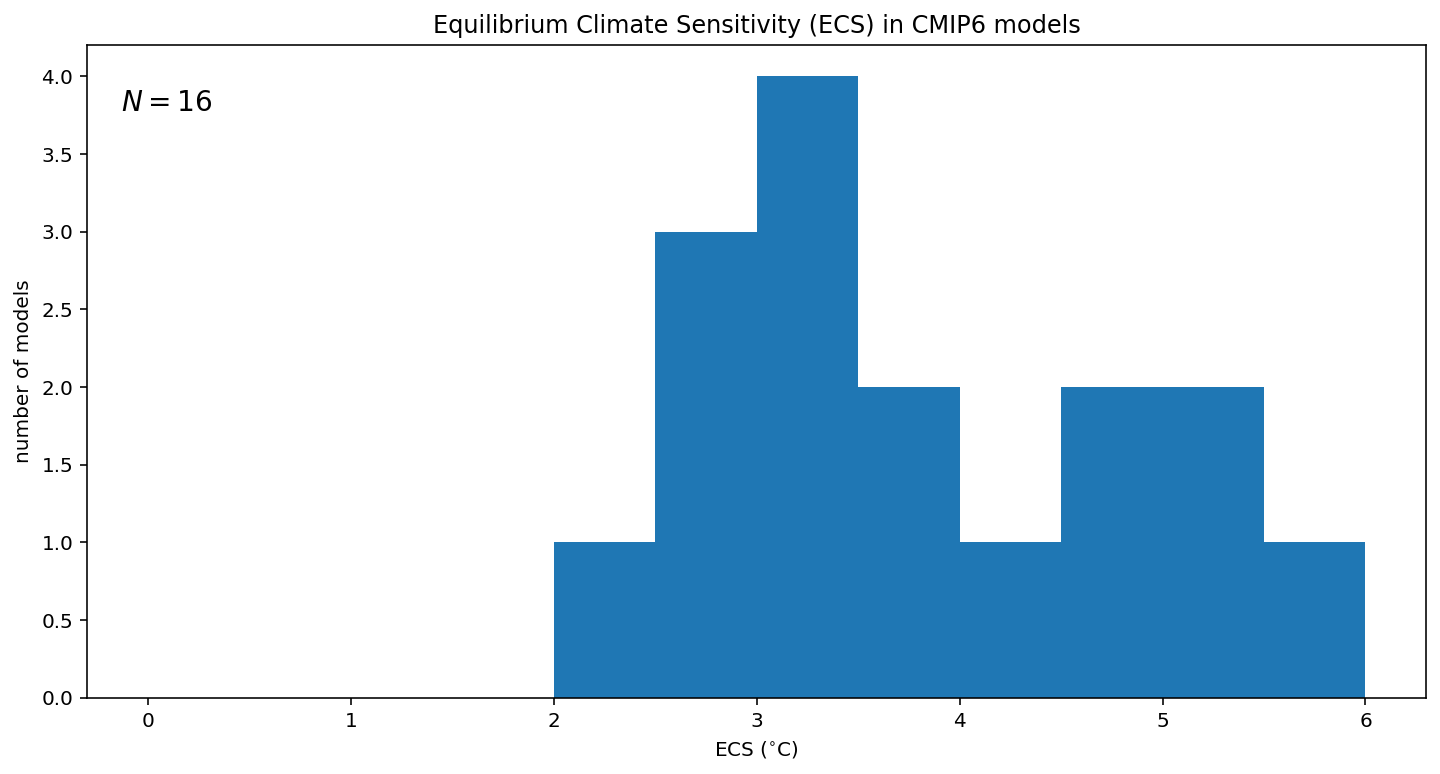

In [38]:
plt.hist(np.array(list(results['ECS'].values())), bins=np.arange(0,max(list(results['ECS'].values()))+0.5,0.5))
plt.xlabel(r"ECS ($^{\circ}$C)")
plt.ylabel("number of models")
plt.title('Equilibrium Climate Sensitivity (ECS) in CMIP6 models')
plt.annotate(s=fr"$N = {len(results['ECS'])}$",xy=(0.025,0.90), xycoords="axes fraction", fontsize=14)
plt.savefig(f"../figures/ECS_Gregory_{gregory_limits[0]}-{gregory_limits[1]}_hist.png",dpi=100)

In [36]:
tmp = sorted(results['ECS'].items(), key=lambda x: x[1])
ordered_ECS = { pair[0]:pair[1] for pair in tmp }

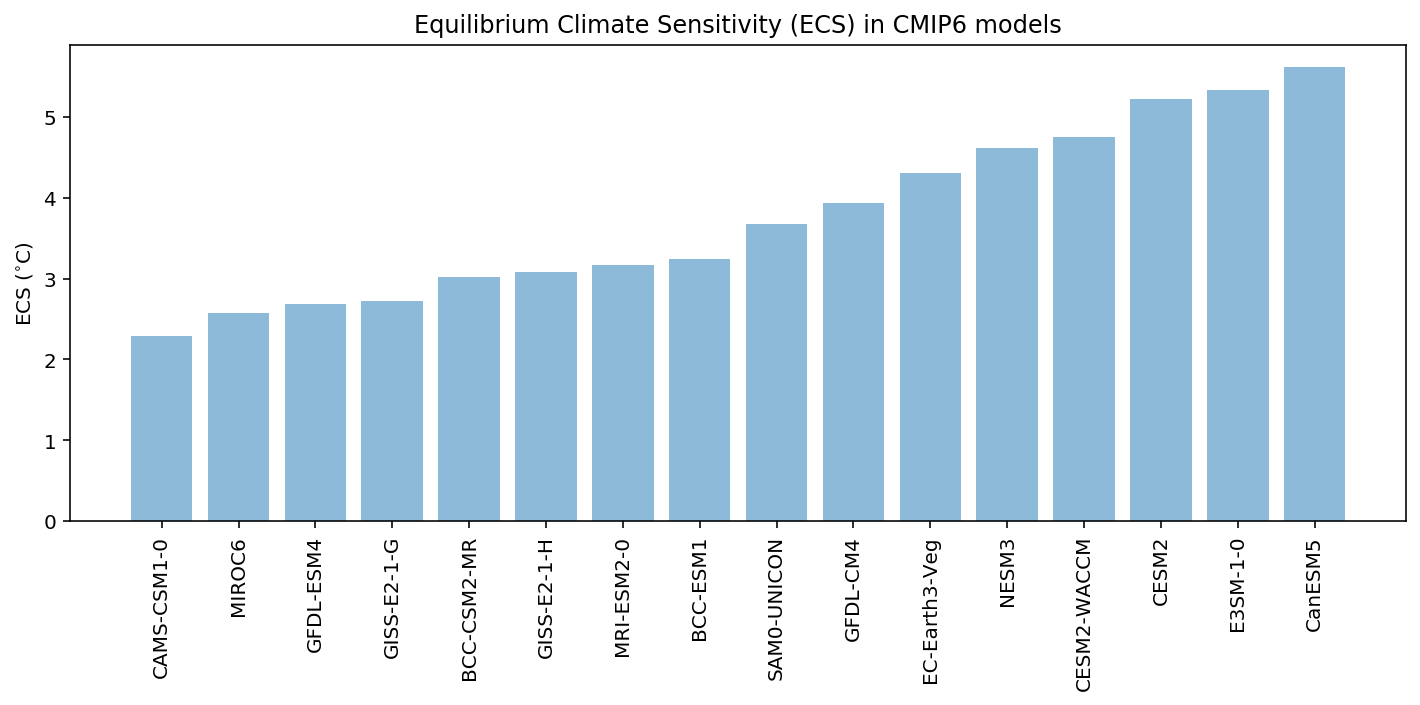

In [37]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(ordered_ECS)), np.array(list(ordered_ECS.values())), align='center', alpha=0.5)
plt.xticks(np.arange(len(ordered_ECS)),ordered_ECS.keys(), rotation=90)
plt.ylabel(r"ECS ($^{\circ}$C)")
plt.title('Equilibrium Climate Sensitivity (ECS) in CMIP6 models')
plt.tight_layout()
plt.savefig(f"../figures/ECS_Gregory_{gregory_limits[0]}-{gregory_limits[1]}_bar.png",dpi=100,bbox_inches='tight')

#### Speed up your code with dask-kubernetes (if available)
```python
# Cluster was created via the dask labextension
# Delete this cell and replace with a new one

from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=10, interval='2s')
client = Client(cluster)
client
```